# **PROJECT 4**

# 🔥 **Detecting Fake News Using Machine Learning 🚀**

### Fake news is a growing problem in today's society, and it can have serious consequences, including influencing public opinion and even shaping policy decisions. In this project, we aim to build a machine learning model that can accurately identify whether a given news article is fake or not.

---

Dataset used - https://www.kaggle.com/fake-news/data

Dataset Description

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable
  * 1: FAKE
  * 0: TRUE

train.csv: The full training dataset, with the labels removed

---


### **Set the dependencies**

In [1]:
import numpy as np
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import inspect
from api_keys import postgres_p
import matplotlib.pyplot as plt
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import itertools
import pickle
import winsound

---


### **Retrieving Text Data from PostgreSQL and Loading into a Pandas DataFrame**

First, the code downloads and loads all stop words from the NLTK corpus. Then, it establishes a connection to a PostgreSQL database named "Project_4" using the psycopg2 library. A SQL query is executed to retrieve data from two tables named "article_id" and "text_corpus" in the database. The data is limited to the first 1000 rows using the LIMIT keyword. The results are stored in a Pandas DataFrame named "news_dataset". Finally, the database connection is closed using the close() method.

In [2]:
# Download and load all stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# check if Stopwords loaded in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

---

### **Data Pre-processing and Analysis**


In [4]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(database="Project_4", user="postgres", password=postgres_p) #host="your_host_address", port="your_port_number"

In [5]:
# SQL query to retrieve the data - Limit to 1000 records for testing and evaluation
query = "SELECT a.article_id, a.article_label, t.text_corpus FROM article_id a  JOIN text_corpus t ON a.article_id = t.article_id LIMIT 5000"

In [6]:
# Execute the query and store the results in a Pandas DataFrame
news_dataset = pd.read_sql_query(query, conn)

In [7]:
# Close the database connection
conn.close()

In [8]:
# Check dataset
news_dataset.head()

,article_id,article_label,text_corpus
0,0,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,1,Consortiumnews.com Why the Truth Might Get You...
3,3,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,1,Howard Portnoy Iranian woman jailed for fictio...


---

### **Text Preprocessing with Stemming, Stop Word Removal, and Lowercasing**

In the following code, the data and label are separated into two variables, X and Y, respectively, from the previously loaded dataset. Then, a function is defined to perform stemming on the text data. 

Stemming is the process of reducing words to their base or root form. The PorterStemmer class from the nltk package is used for stemming. 

The function removes non-alphabetic characters and converts all remaining letters to lowercase. It splits the text into individual words, removes stop words, and applies stemming to each word using the PorterStemmer. Finally, it joins all the words back into a string. 

The apply() method is used to apply the stemming() function to each row of the text_corpus column of the dataset, and the results are stored back in X. 

Lastly, a beep sound is played to signal that the process has completed.

In [9]:
# Separate the data and label into two variables
X = news_dataset['text_corpus']
Y = news_dataset['article_label']

In [10]:
# Define a function for stemming the content
port_stem = PorterStemmer()
def stemming(content):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    # Converting all letters to lowercase 
    stemmed_content = stemmed_content.lower()
    # Converting all to a splitted case or a list
    stemmed_content = stemmed_content.split()
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    # Join all the words in final content
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [11]:
# Apply stemming to the text_corpus column
X = X.apply(stemming)

In [12]:
# Play a sound to let you know its done 
duration = 2000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [13]:
# Print the X and Y variables
print(X)
print(Y)

0       darrel lucu hous dem aid even see comey letter...
1       daniel j flynn flynn hillari clinton big woman...
2       consortiumnew com truth might get fire truth m...
3       jessica purkiss civilian kill singl us airstri...
4       howard portnoy iranian woman jail fiction unpu...
                              ...                        
4995    juliu hubri chill compani mandatori fanci dres...
4996    michael shear carson new sign trump plan gover...
4997    somini sengupta nikki haley call unit nation h...
4998    elizabeth yuko sort around holiday could famil...
4999    sabrina tavernis zika viru case utah baffl hea...
Name: text_corpus, Length: 5000, dtype: object
0       1
1       0
2       1
3       1
4       1
       ..
4995    1
4996    0
4997    0
4998    0
4999    0
Name: article_label, Length: 5000, dtype: int64


---

### **Transforming Text Data with CountVectorizer**

In the following code, a single instance of CountVectorizer is created to convert text data into numerical form. The stop_words parameter is set to 'english' to remove common stop words from the text. The fit() method is called on the vectorizer object to learn the vocabulary of the text data. The transform() method is called on the X variable to convert the text data into a sparse matrix of numerical features. The resulting matrix is stored in X_transformed.

The pickle module is used to save the vectorizer object to a file named "tfidfvect2.pkl" in the "Pickles" directory. The saved object can be loaded and used later for transforming new text data into numerical features.

The print() function is used to display the vectorizer object and the transformed X data. The transformed X data is displayed as a sparse matrix representation.

In [14]:
# Create a single instance of CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

In [15]:
# Fit the vectorizer on the text data
vectorizer.fit(X)

CountVectorizer(stop_words='english')

In [16]:
# Transform the data into numerical features
X_transformed = vectorizer.transform(X)

In [17]:
# Save the vectorizer object to a file using pickle
pickle.dump(vectorizer, open('../Pickles/tfidfvect2.pkl', 'wb'))

In [18]:
# Load the saved object and print it to check if it is loaded correctly
TEST_model = pickle.load(open('../Pickles/tfidfvect2.pkl', 'rb'))
print(TEST_model)

CountVectorizer(stop_words='english')


In [19]:
# Print the transformed data
print(X_transformed)

  (0, 145)	1
  (0, 239)	1
  (0, 294)	3
  (0, 404)	1
  (0, 427)	1
  (0, 598)	1
  (0, 744)	1
  (0, 856)	6
  (0, 1342)	3
  (0, 1509)	1
  (0, 1681)	1
  (0, 1862)	1
  (0, 1902)	1
  (0, 1927)	1
  (0, 2061)	1
  (0, 2132)	1
  (0, 2157)	2
  (0, 2164)	1
  (0, 2872)	1
  (0, 3107)	1
  (0, 3838)	1
  (0, 4081)	1
  (0, 4825)	1
  (0, 5525)	1
  (0, 5909)	1
  :	:
  (4999, 46215)	1
  (4999, 46678)	1
  (4999, 46808)	3
  (4999, 46809)	4
  (4999, 46840)	1
  (4999, 46873)	4
  (4999, 47475)	1
  (4999, 47831)	1
  (4999, 48205)	3
  (4999, 48524)	1
  (4999, 48653)	2
  (4999, 48703)	1
  (4999, 48752)	8
  (4999, 48756)	1
  (4999, 48834)	1
  (4999, 49530)	10
  (4999, 50082)	1
  (4999, 50164)	1
  (4999, 50262)	1
  (4999, 50734)	1
  (4999, 51017)	3
  (4999, 51096)	1
  (4999, 51560)	2
  (4999, 51719)	2
  (4999, 52101)	11


---

### **CLASSIFICATION MODEL : LOGISTIC REGRESSION CLASSIFIER**

The data is split into training and testing sets using the train_test_split function. The test_size parameter is set to 0.18, meaning that 18% of the data will be used for testing, and the remaining 82% for training. The random_state parameter is set to 42 to ensure reproducibility of the results.

In [20]:
# Splitting the data into test and train datasets
X_train_transformed, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size=0.18, random_state=42)

A parameter grid is defined for hyperparameter tuning, including regularization strength C, regularization penalty type (l1 or l2), and solver algorithm (liblinear).

In [21]:
# Define the parameter grid for Logistic Regression
logreg_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [22]:
# Initialize the model
logreg = LogisticRegression()

In [23]:
# Create a single instance of CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

GridSearchCV is used to find the best set of hyperparameters from the parameter grid. Cross-Validation with 5-folds is used to evaluate each set of hyperparameters.

In [24]:
# Perform GridSearchCV for Logistic Regression
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, verbose=0)
logreg_grid_search.fit(X_transformed, Y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

The best hyperparameters found by Grid Search are stored in best_logreg_params and are then used to train the final Logistic Regression model, best_logreg_model.

In [25]:

# Get the best parameters
best_logreg_params = logreg_grid_search.best_params_

In [26]:
# Train the model with best parameters
best_logreg_model = LogisticRegression(**best_logreg_params)

The trained model is used to predict the outcomes on the test set, and the prediction accuracy is calculated as the percentage of correct predictions.

In [27]:
# Calculate the accuracies and record the changes
logreg_accuracies = logreg_grid_search.cv_results_['mean_test_score']

In [28]:
best_logreg_model.fit(X_train_transformed, Y_train)

LogisticRegression(C=78.47599703514607, penalty='l1', solver='liblinear')

The results are displayed, including the accuracy, classification report, and confusion matrix.

In [29]:
y_pred1 = best_logreg_model.predict(X_test)
accuracy1 = np.mean(y_pred1 == Y_test) * 100

print("Logistic Regression Model Results")
print("----------------------------------")
print("Prediction accuracy: {:.2f}%".format(accuracy1))
print("\nClassification Report:")
print("--------------------------------------------")
print(classification_report(Y_test, y_pred1))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred1))
print("\n")

Logistic Regression Model Results
----------------------------------
Prediction accuracy: 95.00%

Classification Report:
--------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       459
           1       0.94      0.96      0.95       441

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900

Confusion Matrix:
[[432  27]
 [ 18 423]]




A plot is created to visualize the accuracy of different sets of hyperparameters during the Grid Search process. 

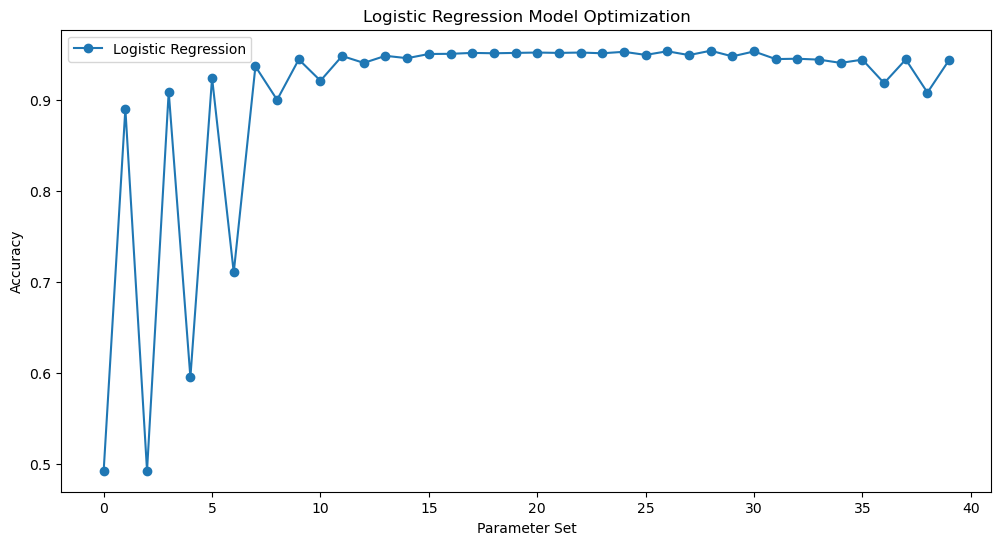

In [30]:
# Plot changes
plt.figure(figsize=(12, 6))
plt.plot(logreg_accuracies, label="Logistic Regression", linestyle="-", marker="o")
plt.xlabel("Parameter Set")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Model Optimization")
plt.legend()
plt.savefig("logreg_model_optimization.png")
plt.show()

The trained model is used to predict the outcomes on the training and test sets, and the prediction accuracy is calculated using the accuracy_score function from the sklearn.metrics module. 

In [31]:
# Accuracy Score on Training Data
X_train_prediction = best_logreg_model.predict(X_train_transformed)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print('Accuracy score on the training data: ',training_data_accuracy)

# Accuracy Score on Test Data
X_test_prediction = best_logreg_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score on the test data: ',test_data_accuracy)

Accuracy score on the training data:  1.0
Accuracy score on the test data:  0.95


The trained Logistic Regression model is saved as a pickle file

In [32]:
pickle.dump(best_logreg_model, open('../Pickles/logisticreg_model.pkl', 'wb'))

---

### **CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER**

Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

A function called stemming is defined to preprocess and stem the input text. The function takes the input text, removes non-alphabetic characters, converts the text to lowercase, tokenizes it, removes stopwords, and applies stemming using the PorterStemmer algorithm.

In [33]:
# Create a function to preprocess and stem the text
def stemming(text):
    ps = PorterStemmer()
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review


The stemming function is applied to each element of X. The preprocessed data is then transformed using the vectorizer, and the dataset is split into training and testing sets.

In [34]:
# Apply stemming to each text in the array
X_preprocessed = [stemming(text) for text in X]

In [35]:
# Fit and transform the preprocessed data
X_transformed = vectorizer.fit_transform(X_preprocessed)

In [36]:
# Splitting dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size=0.33, random_state=42)

A parameter grid is defined for hyperparameter tuning, including regularization strength C, and loss function type (hinge or squared_hinge). GridSearchCV is used to find the best set of hyperparameters from the parameter grid.

In [37]:
# Define the parameter grid for Passive Aggressive Classifier
pac_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'loss': ['hinge', 'squared_hinge']
}

In [38]:
# Initialize the model
pac = PassiveAggressiveClassifier()

In [39]:
# Perform GridSearchCV for Passive Aggressive Classifier
pac_grid_search = GridSearchCV(pac, pac_param_grid, cv=5, verbose=0)
pac_grid_search.fit(X_transformed, Y)

GridSearchCV(cv=5, estimator=PassiveAggressiveClassifier(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'loss': ['hinge', 'squared_hinge']})

In [40]:

# Get the best parameters
best_pac_params = pac_grid_search.best_params_

In [41]:
# Train the model with best parameters
best_pac_model = PassiveAggressiveClassifier(**best_pac_params)


In [42]:
# Calculate the accuracies and record the changes
pac_accuracies = pac_grid_search.cv_results_['mean_test_score']

In [43]:
best_pac_model.fit(X_train, Y_train)

PassiveAggressiveClassifier(C=11.288378916846883, loss='squared_hinge')

The results are displayed, including the accuracy, classification report, and confusion matrix.

A plot is created to visualize the accuracy of different sets of hyperparameters during the Grid Search process. 

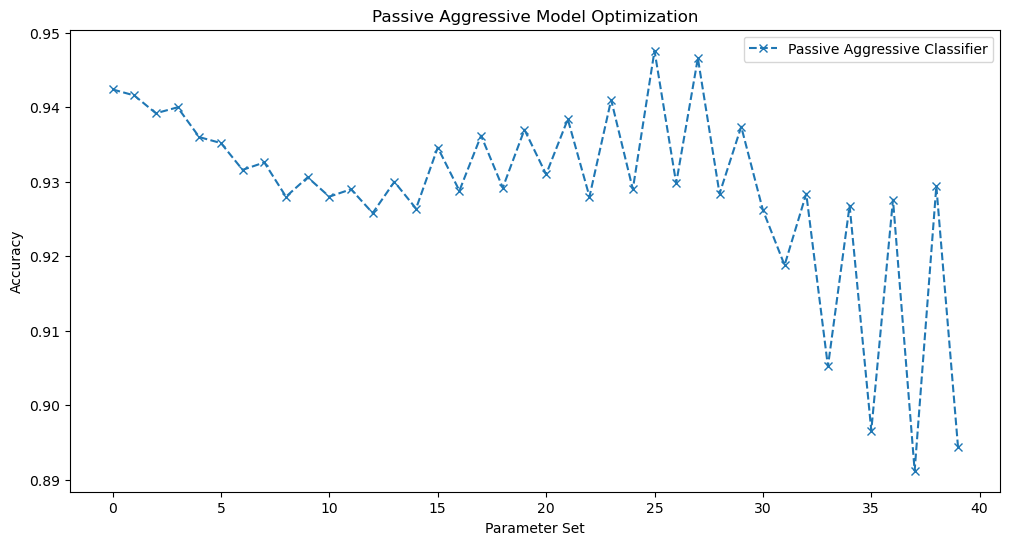

In [44]:
# Plot changes
plt.figure(figsize=(12, 6))
plt.plot(pac_accuracies, label="Passive Aggressive Classifier", linestyle="--", marker="x")
plt.xlabel("Parameter Set")
plt.ylabel("Accuracy")
plt.title("Passive Aggressive Model Optimization")
plt.legend()
plt.savefig("model_optimization.png")
plt.show()

In [45]:
# Passive Aggressive Classifier
y_pred2 = best_pac_model.predict(X_test)
accuracy2 = np.mean(y_pred2 == Y_test) * 100

print("Passive Aggressive Classifier Model Results")
print("--------------------------------------------")
print("Prediction accuracy: {:.2f}%".format(accuracy2))
print("\nClassification Report:")
print("--------------------------------------------")
print(classification_report(Y_test, y_pred2))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred2))

Passive Aggressive Classifier Model Results
--------------------------------------------
Prediction accuracy: 93.15%

Classification Report:
--------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       842
           1       0.92      0.95      0.93       808

    accuracy                           0.93      1650
   macro avg       0.93      0.93      0.93      1650
weighted avg       0.93      0.93      0.93      1650

Confusion Matrix:
[[772  70]
 [ 43 765]]


In [46]:
# Making prediction on test set
test_pred = best_pac_model.predict(X_test)

The trained TfidfVectorizer instance and the Passive Aggressive Classifier model are saved as pickle files

In [47]:
# Save the vectorizer
pickle.dump(vectorizer, open('../Pickles/tfidf_vectorizer.pkl', 'wb'))

In [48]:
# Save the model
pickle.dump(best_pac_model, open('../Pickles/passive_aggressive_model.pkl', 'wb'))

---

## Testing the two models

In [49]:
# Preprocess and vectorize the input data
X_preprocessed = [stemming(text) for text in X]


In [50]:
# Splitting dataset into train and test sets
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X_preprocessed, Y, test_size=0.18, random_state=42)



In [51]:
# Fit the vectorizer on the training data and transform both the training and test data
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [52]:
# Retrain the Logistic Regression model with the best parameters
best_logreg_model = LogisticRegression(**best_logreg_params)
best_logreg_model.fit(X_train, Y_train)

LogisticRegression(C=78.47599703514607, penalty='l1', solver='liblinear')

In [53]:
# Test Logistic Regression Model
y_pred = best_logreg_model.predict(X_test)
accuracy = np.mean(y_pred == Y_test) * 100
print("Logistic Regression Model Prediction Accuracy: {:.2f}%".format(accuracy))



Logistic Regression Model Prediction Accuracy: 95.00%


In [54]:
# Retrain the Passive Aggressive Classifier model with the best parameters
best_pac_model = PassiveAggressiveClassifier(**best_pac_params)
best_pac_model.fit(X_train, Y_train)

PassiveAggressiveClassifier(C=11.288378916846883, loss='squared_hinge')

In [55]:
# Test Passive Aggressive Classifier Model
y2_pred = best_pac_model.predict(X_test)
accuracy = np.mean(y2_pred == Y_test) * 100
print("Passive Aggressive Classifier Model Prediction Accuracy: {:.2f}%".format(accuracy))


Passive Aggressive Classifier Model Prediction Accuracy: 94.56%


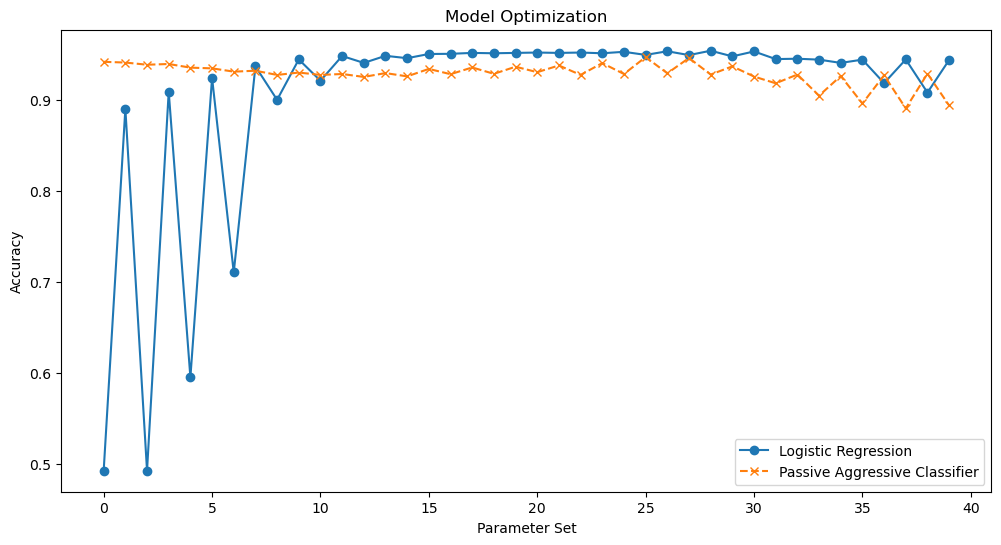

In [56]:
# Plot both models
plt.figure(figsize=(12, 6))
plt.plot(logreg_accuracies, label="Logistic Regression", linestyle="-", marker="o")
plt.plot(pac_accuracies, label="Passive Aggressive Classifier", linestyle="--", marker="x")
plt.xlabel("Parameter Set")
plt.ylabel("Accuracy")
plt.title("Model Optimization")
plt.legend()
plt.savefig("model_optimization.png")
plt.show()